In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pandas as pd
import os
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random


In [2]:
kaggle_env = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive'

In [3]:
class ImageDataset(Dataset):
    def __init__(self, images_folder_path, labels_file_path, transform=None):
        labels = pd.read_csv(labels_file_path) 
        labels['count'] = labels['count'].astype(float)
        self.labels = labels 
        
        self.images_path = images_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):   
        image_file, label = self.labels.iloc[index]
        img = Image.open(os.path.join(self.images_path, image_file))
         
        if self.transform:
            img = self.transform(img)
            
        return img, label


In [4]:
if kaggle_env:
    train_data_path = '/kaggle/input/image-regression-data/data/train'
    test_data_path = '/kaggle/input/image-regression-data/data/test'
else:
    train_data_path = 'data/train'
    test_data_path = 'data/test'

data_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


train_dataset = ImageDataset(
    f'{train_data_path}/images/', 
    f'{train_data_path}/annotations.csv', 
    data_transforms)

test_dataset = ImageDataset(
    f'{test_data_path}/images/', 
    f'{test_data_path}/annotations.csv', 
    data_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 

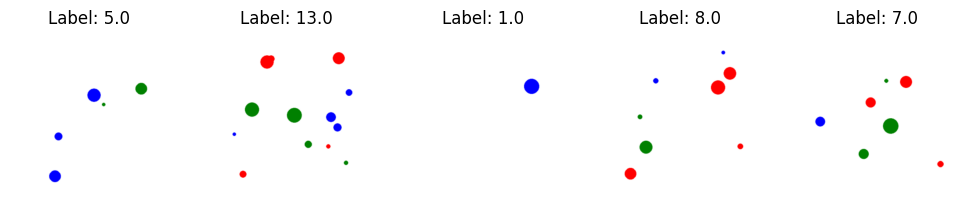

In [13]:
def show_images(images, captions): 
    def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        tensor = tensor.clone() 
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor
 
    plt.figure(figsize=(len(images) * 2, 2))
    
    for i, (image, label) in enumerate(zip(images, captions)):  
        if isinstance(image, torch.Tensor):
            image = denormalize(image)
            image = image.permute(1, 2, 0)  # CxHxW -> HxWxC
 
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image.numpy())
        plt.title(f"{label}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

indices = random.sample(range(len(train_dataset)), 5)
random_train_samples = [train_dataset[i] for i in indices]
random_train_images = [sample[0] for sample in random_train_samples]
random_train_captions = [f'Label: {sample[1]}' for sample in random_train_samples]
  
show_images(random_train_images, random_train_captions)


In [6]:

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        # self.main = nn.Sequential(
        #     nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2),
        #     nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0), 
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2),   
        # ) 
        
        self.resnet = models.resnet50(pretrained=True).requires_grad_(False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1024)

        self.fc = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x
    

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNNModel()
model.to(device)


lr = 1e-4
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr) 

epochs = 50

C:\Users\majed\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\majed\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model.train()

# loop over the dataset multiple times
for epoch in tqdm(range(epochs), total=epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.float()
        inputs, labels = inputs.to(device), labels.to(device) 

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Loss: {}'.format(running_loss))

print('Finished Training')

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model.eval()
total_loss = 0.0
num_samples = 0

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, total=len(test_loader)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = F.mse_loss(outputs, targets, reduction='sum')  # sum to later average manually

        total_loss += loss.item()
        num_samples += targets.size(0)

    mse = total_loss / num_samples

print('Test MSE', mse)

  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\majed\AppData\Local\Temp\ipykernel_1836\563550850.py:11: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, targets, reduction='sum')  # sum to later average manually
C:\Users\majed\AppData\Local\Temp\ipykernel_1836\563550850.py:11: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, targets, reduction='sum')  # sum to later average manually


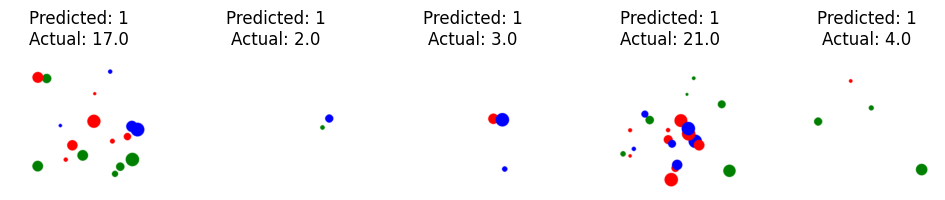

In [17]:
indices = random.sample(range(len(test_dataset)), 5)
random_test_samples = [test_dataset[i] for i in indices]
random_test_images = [sample[0] for sample in random_test_samples] 

random_test_captions = []   
for image, target in random_test_samples:
    image = image.unsqueeze(0).to(device)
    output = round(model(image).item())
    
    random_test_captions.append(f'Predicted: {output}\nActual: {target}')

     
show_images(random_test_images, random_test_captions)